# This notebook handles ingestion of stocks data to feature store

In [1]:
# prerequisits for the notebook is installing 2 packages yfinance yahoo_fin for uploading stocks data 
#%pip install yfinance yahoo_fin

> <b> Steps </b>
>  * [Creating mlrun function that reads stocks from yfinance and returning record oriented json](#Creating-mlrun-function-that-reads-news-from-yfinance-and-returning-record-oriented-json)
>  * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
>  * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
>  * [Testing ingestion service](#Testing-ingestion-service)
>  * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta) 

In [2]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-05-19 12:26:43,318 [info] loaded project stocks from MLRun DB


## Creating mlrun function that reads stocks from yfinance and returning record oriented json
Unlike any other feature-set serving graph (where the data is sent as an event to the graph) we collect the data from within the graph.<br>
the event sent to the graph specify real-time configuration.

In [3]:
#mlrun: start-code

import yahoo_fin.stock_info as si
import datetime
import yfinance as yf
import pandas as pd
import json
from storey import Event

def get_stocks(event):
    '''
    event: dict with the following keys:
    start_delta - start collecting the data days back
    end_delta - collect data untill days back
    interval - interval of collected stocks data
    n_stocks - how many stocks to collect
    '''
    # getting stock names
    tickers = si.tickers_sp500()[:event['n_stocks']]
    # time deltas to scrape data
    start = datetime.datetime.now()-datetime.timedelta(event['start_delta'])
    end = datetime.datetime.now()-datetime.timedelta(event['end_delta'])
    interval = event['interval']
    
    # collecting data from yfinance
    return_list = []
    for ticker in tickers:
        hist = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
        hist['ticker'] = ticker
        hist['ticker2onehot'] = ticker
        return_list.append(hist)
        
    # some data manipulations
    df = pd.concat(return_list).reset_index().drop(axis=1,columns=['Dividends','Stock Splits'])
    print(f"downloaded {len(tickers)} stocks data with size of {df.shape}")  
    df['Datetime']= df['Datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    
    return json.loads(df.to_json(orient='records'))

def gen_event_key(event): # since using nosql as target, each event must have its key - therefore this step is needed !
    return Event(event.body,key=event.body['ticker'])

#mlrun: end-code

## Creating a feature set and declaring the graph 

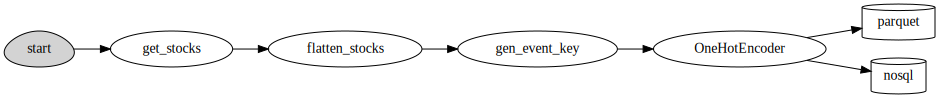

In [4]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, OneHotEncoder
import yahoo_fin.stock_info as si

stocks_set = fstore.FeatureSet("stocks_data", 
                             entities=[fstore.Entity("ticker")],
                             timestamp_key='Datetime', 
                             description="stocks feature set")

# how many tickers data we ingest (make sure same number used for ingesting news)
n_tickers = 4


stocks_set.graph\
        .to(name='get_stocks',handler='get_stocks')\
        .to("storey.steps.Flatten", name="flatten_stocks")\
        .to(name='gen_event_key',handler='gen_event_key',full_event=True)\
        .to(OneHotEncoder(mapping={'ticker2onehot':{ticker:str(idx) for idx,ticker in enumerate(si.tickers_sp500()[:n_tickers])}}))\
    
# Setting default targets (nosql & parquet)
stocks_set.set_targets(with_defaults=True) 
stocks_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [5]:
import os 
import datetime

# ingesting dummy (A MUST) 
name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(stocks_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'start_delta':7,
                                      'end_delta':3,
                                      'interval':'5m',
                                      'n_stocks':4}))

downloaded 4 stocks data with size of (628, 8)
downloaded 4 stocks data with size of (628, 8)


Datetime        Open        High         Low  \
ticker                                                                        
A      2022-05-19 12:26:51.934928+00:00  113.610001  113.919998  112.779999   
A      2022-05-19 12:26:51.935324+00:00  113.099998  113.480003  113.099998   
A      2022-05-19 12:26:51.935519+00:00  113.599998  114.000000  113.419998   
A      2022-05-19 12:26:51.935697+00:00  114.010002  115.139999  114.010002   
A      2022-05-19 12:26:51.935877+00:00  114.559998  115.309998  114.400002   
...                                 ...         ...         ...         ...   
AAPL   2022-05-19 12:26:52.039717+00:00  146.789993  147.210007  146.699997   
AAPL   2022-05-19 12:26:52.039951+00:00  147.024994  147.309998  146.570007   
AAPL   2022-05-19 12:26:52.040142+00:00  146.729996  146.929993  145.919998   
AAPL   2022-05-19 12:26:52.040312+00:00  146.699997  147.160004  146.399994   
AAPL   2022-05-19 12:26:52.040480+00:00  140.820007  140.820007  140.820007   

             Close   Volume  ticker2onehot_A  ticker2onehot_AAL  \
ticker                                                            
A       113.120003    70229                1                  0   
A       113.480003     6275                1                  0   
A       113.769997     6683                1                  0   
A       114.559998     8139                1                  0   
A       115.059998     7795                1                  0   
...            ...      ...              ...                ...   
AAPL    147.024994  1457925                0                  0   
AAPL    146.729996  1616737                0                  0   
AAPL    146.699997  2869763                0                  0   
AAPL    147.130005  3290561                0                  0   
AAPL    140.820007        0                0                  0   

        ticker2onehot_AAP  ticker2onehot_AAPL  
ticker                                         
A                       0                   0  
A                       0                   0  
A                       0                   0  
A                       0                   0  
A                       0                   0  
...                   ...                 ...  
AAPL                    0                   1  
AAPL                    0                   1  
AAPL                    0                   1  
AAPL                    0                   1  
AAPL                    0                   1  

[628 rows x 10 columns]

In [6]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
stocks_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_stocks',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin', 'yfinance'])

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [7]:
# Deploying
stocks_set_endpoint = fstore.deploy_ingestion_service(featureset=stocks_set, run_config=run_config)

> 2022-05-19 12:26:58,140 [info] Starting remote function deploy
2022-05-19 12:26:58  (info) Deploying function
2022-05-19 12:26:58  (info) Building
2022-05-19 12:26:58  (info) Staging files and preparing base images
2022-05-19 12:26:58  (info) Building processor image
2022-05-19 12:27:43  (info) Build complete
2022-05-19 12:27:57  (info) Function deploy complete
> 2022-05-19 12:27:58,302 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-avia-get-stocks.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-avia-get-stocks-stocks-avia.default-tenant.app.app-lab-eks-b71.iguazio-cd0.com/']}


## Testing ingestion service

In [8]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(stocks_set_endpoint,json={'ticker':['stocks'],
                                                 'Datetime': now,
                                                 'start_delta':3,
                                                 'end_delta':0,
                                                 'interval':'5m',
                                                 'n_stocks':4})
t.text

'{"id": "b31c0334-972d-43d8-8314-dfaf80fddba9"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [9]:
os.makedirs('src',exist_ok=True)

In [10]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['stocks'],
                                     'Datetime': now,
                                     'start_delta':1,
                                     'end_delta':0,
                                     'interval':'5m',
                                     'n_stocks':4})

Overwriting src/invoker.py


In [11]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_stocks',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':stocks_set_endpoint}, schedule='0 8 * * *')

> 2022-05-19 12:27:58,463 [info] starting run ingestion-service-stocks-ingestion_service_invoker uid=76d9f106299045e0a15a5505766bd420 DB=http://mlrun-api:8080
> 2022-05-19 12:27:58,710 [info] task scheduled, {'schedule': '0 8 * * *', 'project': 'stocks-avia', 'name': 'ingestion-service-stocks-ingestion_service_invoker'}
